In [1]:
# Testing whether the projected LM approach works
#  Without the constraints, the problem admits both +x and -x as solutions.
# With the constraints, we should only get +x

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sopt.optimizers.tensorflow2.lma import LMA

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
x_true = np.ones(20, dtype='float32') * 2

random_mat = np.random.randn(20,20)
A = random_mat @ random_mat

# The output data could be from x=2 or x=-2.
y = np.reshape(A @ x_true**2, [-1])

In [5]:
x_guess = np.random.randn(20).astype('float32') * 10

# LMA - linesearch for damping param

In [7]:
# x = 0 is also a stationary point. We are trying to avoid that by using clip_value_min > 0
constraint_fn = lambda x: tf.clip_by_value(x, clip_value_min=0.1, clip_value_max=2.1)
var_constr = tf.Variable(x_guess, dtype='float32', constraint=constraint_fn)
var_unconstr = tf.Variable(x_guess, dtype='float32')

y_t = tf.constant(y, dtype='float32')
A_t = tf.constant(A, dtype='float32')                   
                   
x_true_t = tf.constant(x_true, dtype='float32', name='x_true')

def preds_fn(guess_var):
    return tf.reshape(A_t @ guess_var[:,None]**2, [-1])
def loss_fn(y_pred):
    return 0.5 * tf.reduce_sum((y_pred - y_t)**2)

error_fn = lambda v: tf.reduce_sum((v - x_true_t)**2) / x_true.size

proj_lma_opt = LMA(var_constr, preds_fn, loss_fn, name='constr_opt', mu=1e-4, 
                   diag_hessian_fn=lambda x: 1.0,
                   mu_contraction=0.25, 
                   mu_expansion=4.0,
                   min_cg_tol=1e-5, assert_tolerances=False)

unconstr_lma_opt = LMA(var_unconstr, preds_fn, loss_fn, name='unconstr_opt', mu=1e-4,
                       diag_hessian_fn=lambda x: 1.0,
                       mu_contraction=0.25,
                       mu_expansion=4.0,
                       min_cg_tol=1e-5, assert_tolerances=False)

In [9]:
losses_constr = []
errors_constr = []
losses_unconstr = []
errors_unconstr = []
for i in range(200):
    losses_constr.append(proj_lma_opt.minimize())
    losses_unconstr.append(unconstr_lma_opt.minimize())
    errors_constr.append(error_fn(var_constr))
    errors_unconstr.append(error_fn(var_unconstr))

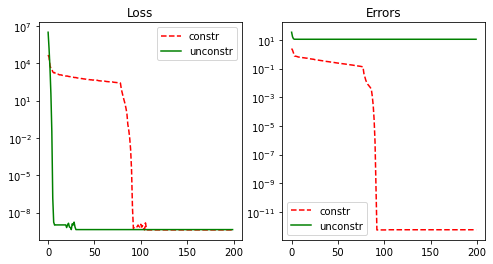

In [10]:

plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(losses_constr, color='red', ls='--', label='constr')
plt.plot(losses_unconstr, color='green', label='unconstr')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(errors_constr, color='red', ls='--', label='constr')
plt.plot(errors_unconstr, color='green', label='unconstr')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Errors')
plt.show()

In [12]:
var_unconstr.numpy(), var_constr.numpy()

(array([-2.0000005, -2.       , -2.0000007, -1.9999995,  1.9999992,
        -2.       ,  1.9999999, -1.9999992,  2.0000005,  2.0000005,
        -2.0000005, -2.0000012, -2.0000002, -1.9999994, -2.0000017,
        -1.9999999,  1.9999992, -1.9999995,  1.9999986, -2.0000005],
       dtype=float32),
 array([2.0000007, 2.0000002, 2.0000007, 1.9999995, 1.9999992, 1.9999999,
        1.9999999, 1.9999993, 2.0000002, 2.0000005, 2.0000005, 2.0000014,
        1.9999999, 1.9999992, 2.0000014, 2.       , 1.9999993, 1.999999 ,
        1.9999987, 2.0000005], dtype=float32))

In [13]:
[
    proj_lma_opt._iteration.numpy(), 
    proj_lma_opt._total_cg_iterations.numpy(),
    proj_lma_opt._total_proj_ls_iterations.numpy(), 
    unconstr_lma_opt._iteration.numpy(), 
    unconstr_lma_opt._total_cg_iterations.numpy()
]

[240, 5703, 139, 200, 1522]

# LM without linesearch 

In [19]:
var_constr = tf.Variable(x_guess, dtype='float32', constraint=constraint_fn)
var_unconstr = tf.Variable(x_guess, dtype='float32')

proj_lma_opt = LMA(var_constr, preds_fn, loss_fn, name='constr_opt', min_cg_tol=1e-5, assert_tolerances=False, max_mu_linesearch_iters=1)

unconstr_lma_opt = LMA(var_unconstr, preds_fn, loss_fn, name='unconstr_opt', min_cg_tol=1e-5, assert_tolerances=False, max_mu_linesearch_iters=1)


In [20]:
losses_constr = []
errors_constr = []
losses_unconstr = []
errors_unconstr = []
for i in range(200):
    losses_constr.append(proj_lma_opt.minimize())
    losses_unconstr.append(unconstr_lma_opt.minimize())
    errors_constr.append(error_fn(var_constr))
    errors_unconstr.append(error_fn(var_unconstr))

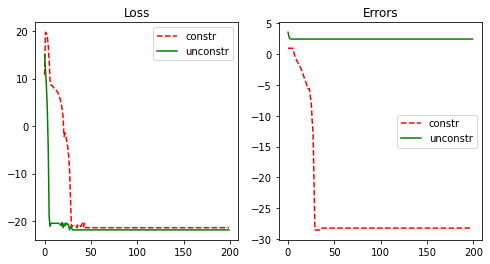

In [21]:

plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(np.log(losses_constr), color='red', ls='--', label='constr')
plt.plot(np.log(losses_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(np.log(errors_constr), color='red', ls='--', label='constr')
plt.plot(np.log(errors_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Errors')
plt.show()

In [24]:
var_unconstr.numpy(), var_constr.numpy()

(array([-1.9999998, -1.9999999, -1.9999999, -2.0000002,  2.       ,
        -1.9999998,  1.9999999, -2.       ,  2.       ,  2.       ,
        -1.9999999, -1.9999996, -1.9999999, -2.0000002, -1.9999999,
        -2.0000002,  2.0000002, -1.9999999,  1.9999999, -1.9999999],
       dtype=float32),
 array([2.000001 , 2.       , 2.0000005, 2.       , 1.9999994, 2.0000005,
        1.9999996, 1.9999992, 2.0000005, 2.0000007, 2.0000002, 2.0000017,
        2.0000002, 1.9999994, 2.0000012, 2.0000005, 1.9999992, 1.9999994,
        1.9999987, 2.0000002], dtype=float32))

In [25]:
[
    proj_lma_opt._iteration.numpy(), 
    proj_lma_opt._total_cg_iterations.numpy(),
    proj_lma_opt._total_proj_ls_iterations.numpy(), 
    unconstr_lma_opt._iteration.numpy(), 
    unconstr_lma_opt._total_cg_iterations.numpy()
]

[200, 1892, 0, 200, 1492]